### Predicting real disaster tweet using GloVe and LSTM
##### Dahai Liu
The project aims at using machine learning and NLP to build a model that distinguishes tweets that are related to an actual disaster. The dataset contains the text of the tweet and the lebel (real disaster or not real disaster). Also, a dataset of pre-trained global vectors for word representation was provided. After some data wrangling and exploratory data analysis, Keras API with Tensorflow backend was used to train a neural network, yielding a validation accuracy of 0.77 on the balanced dataset. Additionally, insights were discovered that real disaster tweets tend to have greater average lengths and the language is more formal, it also uses words like “outbreak”, “wreckage”, and “debris” which are not used in those non-disaster tweets. 

In [1]:
#Load packages
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import defaultdict
from collections import  Counter
from matplotlib import pyplot as plt
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv', sep=',')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv',sep=',')
df_train.shape


(7613, 5)

### Fixing data source error
There are several tweets in the dataset are incorrectly labeled. In fact, they are not disaster related by they are labeled so. This will actually harm the model performance. 

In [3]:
ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]

train_orig = df_train 
train_orig[train_orig['id'].isin(ids_with_target_error)]

train_orig.at[train_orig['id'].isin(ids_with_target_error),'target'] = 0

train_orig[train_orig['id'].isin(ids_with_target_error)]

df_train = train_orig

### EDA

In [4]:
#### Check missing values
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

[Text(0, 0, '0: Not Disaster (4342)'), Text(0, 0, '1: Disaster (3271)')]

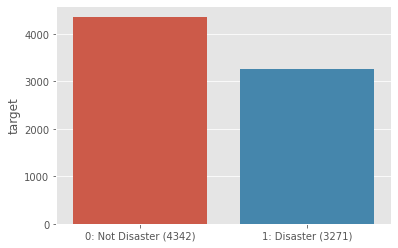

In [5]:
### Check distribution of class labels. 
x = df_train.target.value_counts()
countplt = sns.barplot(x.index,x)
countplt.set_xticklabels(['0: Not Disaster (4342)', '1: Disaster (3271)'])
#plt.gca().set_ylabel('samples')

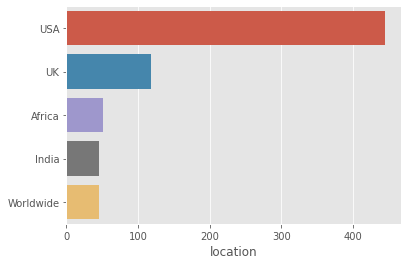

In [6]:
### Plot tweets distribution over locations, that are aggregated in to a country's level
train = df_train
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],
            orient='h')


In [7]:
## examine the "keyword" distribution
df_train['keyword'].value_counts()

fatalities               45
deluge                   42
armageddon               42
body%20bags              41
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [8]:
print('keywords for disaster tweets:','\n', df_train[df_train.target==1].keyword.value_counts().head(10), '\n')
print('keywords for non-disaster tweets:','\n',df_train[df_train.target==0].keyword.value_counts().head(10))

keywords for disaster tweets: 
 outbreak             39
derailment           39
wreckage             39
oil%20spill          37
debris               37
typhoon              37
evacuated            32
suicide%20bomb       32
rescuers             32
suicide%20bombing    32
Name: keyword, dtype: int64 

keywords for non-disaster tweets: 
 body%20bags    40
armageddon     37
harm           37
ruin           36
wrecked        36
deluge         36
twister        35
siren          35
explode        35
fear           35
Name: keyword, dtype: int64


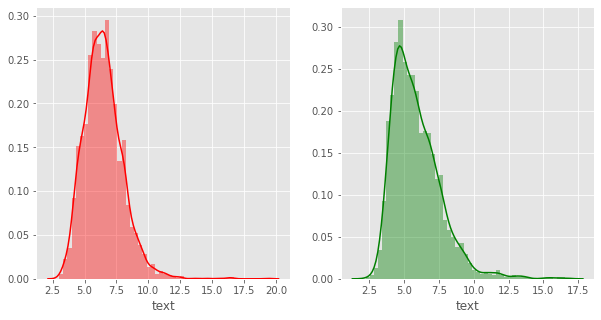

In [9]:
tweet = df_train
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

word=tweet[tweet['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
#ax1.set_title('disaster')
word=tweet[tweet['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
#ax2.set_title('Not disaster')
#fig.suptitle('Average word length in each tweet')

### As we can see, tweet with disasters have greater average lenth of text. 

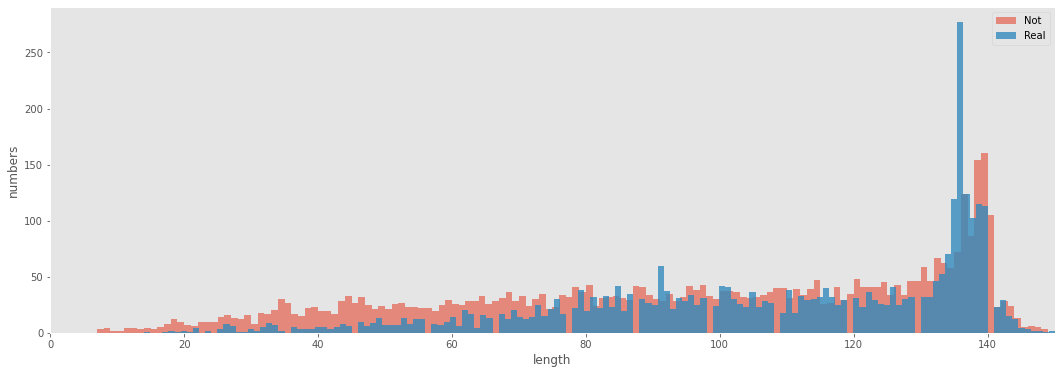

In [10]:
### Tweet lenghths distributions comparison between real disaster tweet and non-disaster ones
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
tweet = df_train
tweet['length'] = tweet['text'].apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(tweet[tweet['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(tweet[tweet['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

## Data cleaning
remove urls, html, emoji, punctuation

spell checker

In [11]:
df=pd.concat([df_train,df_test])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [12]:
df

,id,keyword,length,location,target,text
0,1,NaN,69.0,NaN,1.0,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,38.0,NaN,1.0,Forest fire near La Ronge Sask. Canada
2,5,NaN,133.0,NaN,1.0,All residents asked to 'shelter in place' are ...
3,6,NaN,65.0,NaN,1.0,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,88.0,NaN,1.0,Just got sent this photo from Ruby #Alaska as ...
...,...,...,...,...,...,...
3258,10861,NaN,NaN,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [13]:
!pip install pyspellchecker

     |████████████████████████████████| 1.9 MB 7.9 MB/s eta 0:00:01


In [14]:

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_URL(x))


def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text'].apply(lambda x : remove_html(x))
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


df['text']=df['text'].apply(lambda x: remove_emoji(x))

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text
df['text']=df['text'].apply(lambda x: clean_text(x))


## Model Building

In [15]:
### Turn cleaned tweets into corpus (lower case, non stop, alphabetical words)
from tqdm import tqdm ### This is for a progress bar
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus
corpus=create_corpus(df)


100%|██████████| 10876/10876 [00:03<00:00, 3039.80it/s]


In [16]:
### Generate embedding dict from the GloVe txt file. So in the dictionary, every word is 
### associated with the GloVe representation of them
import numpy as np
embedding_dict={}

with open('../input/glove-global-vectors-for-word-representation/glove.6B.50d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [17]:
MAX_LEN=50
tokenizer_obj=Tokenizer() ## Initialize tokenizer
tokenizer_obj.fit_on_texts(corpus) 
sequences=tokenizer_obj.texts_to_sequences(corpus)### Convert each tweet in the corpus into sequence of numbers

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')### Pad the sequences so that they have the same length

word_index=tokenizer_obj.word_index
word_index
#Now each word in the corpus is associated with a number representing the location it is in the sequence

{'i': 1,
 'the': 2,
 'amp': 3,
 'like': 4,
 'a': 5,
 'fire': 6,
 'get': 7,
 'via': 8,
 'new': 9,
 'news': 10,
 'people': 11,
 'one': 12,
 'in': 13,
 'would': 14,
 'video': 15,
 'emergency': 16,
 'disaster': 17,
 'it': 18,
 'this': 19,
 'to': 20,
 'police': 21,
 'you': 22,
 'is': 23,
 'still': 24,
 'got': 25,
 'us': 26,
 'my': 27,
 'body': 28,
 'storm': 29,
 'burning': 30,
 'suicide': 31,
 'crash': 32,
 'rt': 33,
 'first': 34,
 'attack': 35,
 'time': 36,
 'back': 37,
 'know': 38,
 'california': 39,
 'fires': 40,
 'see': 41,
 'going': 42,
 'buildings': 43,
 'and': 44,
 'ca': 45,
 'man': 46,
 'today': 47,
 'world': 48,
 'day': 49,
 'two': 50,
 'love': 51,
 'bomb': 52,
 'nuclear': 53,
 'full': 54,
 'hiroshima': 55,
 'we': 56,
 'go': 57,
 'youtube': 58,
 'if': 59,
 'watch': 60,
 'dead': 61,
 'life': 62,
 'train': 63,
 'think': 64,
 'car': 65,
 'could': 66,
 'last': 67,
 'killed': 68,
 'accident': 69,
 'of': 70,
 'say': 71,
 'good': 72,
 'war': 73,
 'make': 74,
 'gt': 75,
 'no': 76,
 'what':

In [18]:
### Generate embedding matrix using the dictionary "embedding_dict={}" from GloVe
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,50))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 18694/18694 [00:00<00:00, 335857.65it/s]


In [19]:
### Train test split
train=tweet_pad[:tweet.shape[0]]
test=tweet_pad[tweet.shape[0]:]
X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)

### Neural Network Architecture

In [20]:
### Neural Network
model=Sequential() ### Initiate neural network

embedding=Embedding(num_words,50,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False) ### First layer is the embedding layer

model.add(embedding) ## Add the GloVe embedding layer

model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2)) ### RNN
model.add(Dense(1, activation='sigmoid')) ### Sigmoid for binary classification


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])


In [21]:


model.summary() 



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 50)            934750    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 964,255
Trainable params: 29,505
Non-trainable params: 934,750
_________________________________________________________________


### Make Prediction

In [22]:

## Train the model
history=model.fit(X_train,y_train,batch_size=4,epochs=10,validation_data=(X_test,y_test),verbose=True)



Train on 6471 samples, validate on 1142 samples
Epoch 1/10
6471/6471 [==============================] - 89s 14ms/step - loss: 0.6913 - accuracy: 0.5675 - val_loss: 0.6861 - val_accuracy: 0.5954
Epoch 2/10
6471/6471 [==============================] - 84s 13ms/step - loss: 0.6512 - accuracy: 0.6297 - val_loss: 0.5720 - val_accuracy: 0.7566
Epoch 3/10
6471/6471 [==============================] - 83s 13ms/step - loss: 0.6012 - accuracy: 0.7133 - val_loss: 0.5427 - val_accuracy: 0.7574
Epoch 4/10
6471/6471 [==============================] - 82s 13ms/step - loss: 0.5810 - accuracy: 0.7289 - val_loss: 0.5325 - val_accuracy: 0.7574
Epoch 5/10
6471/6471 [==============================] - 80s 12ms/step - loss: 0.5749 - accuracy: 0.7305 - val_loss: 0.5273 - val_accuracy: 0.7592
Epoch 6/10
6471/6471 [==============================] - 81s 12ms/step - loss: 0.5619 - accuracy: 0.7439 - val_loss: 0.5234 - val_accuracy: 0.7653
Epoch 7/10
6471/6471 [==============================] - 79s 12ms/step - loss

In [23]:


predictions=model.predict(test)
predictions=np.round(predictions).astype(int).reshape(3263)


In [24]:
sample_submission = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

In [25]:
sample_submission["target"] = predictions

In [26]:
sample_submission.tail(50)

,id,target
3213,10668,0
3214,10670,0
3215,10674,0
3216,10683,0
3217,10694,0
3218,10697,1
3219,10699,0
3220,10701,0
3221,10703,0
3222,10713,0


In [27]:
sample_submission.to_csv("submission.csv", index=False)

### Model Evaluation

In [28]:
from tensorflow.keras import metrics
METRICS = [
      metrics.TruePositives(name='tp'),
      metrics.FalsePositives(name='fp'),
      metrics.TrueNegatives(name='tn'),
      metrics.FalseNegatives(name='fn'), 
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc')]

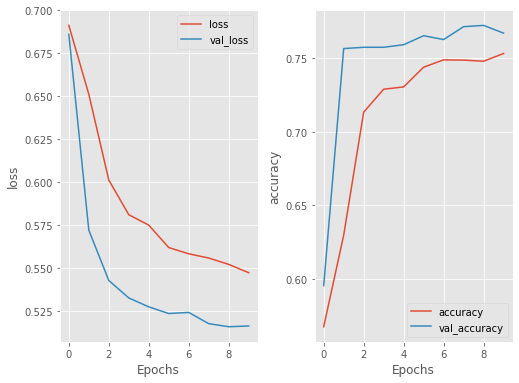

In [29]:
import matplotlib.gridspec as gridspec
def plot_model_eval(history):

    string = ['loss', 'accuracy']  
    cnt = 0
    ncols, nrows = 2, 1  
    fig = plt.figure(constrained_layout=True, figsize = (10,10))
    gs = gridspec.GridSpec(ncols = 3, nrows = 2, figure = fig)
    for i in range(nrows):
        for j in range(ncols):
            ax = plt.subplot(gs[i,j]) 
            ax.plot(history.history[string[cnt]])
            ax.plot(history.history['val_'+string[cnt]]) 
            ax.set_xlabel("Epochs")
            ax.set_ylabel(string[cnt])
            ax.legend([string[cnt], 'val_'+string[cnt]])
            cnt +=1
        
plot_model_eval(history)



### Prediction using new tweets from Twitter

Next, we use Twitter API to prepare a dataset of 1000 tweets that contains the word 'covid' (case insensitive) to see the recall of our model (% of real disaster tweets identified) on new real new tweets from Twitter.
We assume that all tweets containing 'covid' are disaster tweets, so the true-labeled proportion is the recall of our model on the new tweets.

In [31]:
!pip install tweepy

In [32]:
import tweepy
import json

In [33]:
#API Keys
CONSUMER_KEY = 'UtRoBSnR38yyn5wFkWsqRqFiU'
CONSUMER_SECRET = '6XXbta8pgQR6lpiFuj1yzdZWGTgupiCNTNOlLNvV3Wq6w7LoOA'

#Access Tokens
OAUTH_TOKEN = '237972429-8LQBXOK1vdEJmi2ZAkxrZK9KdpLgcsmL5YkpOZDO'
OAUTH_SECRET = 'a82bJ0KCKLbE36oBcD9P20HZjmS3rmUsVwM0mBBnOXGFa'
auth = tweepy.OAuthHandler(CONSUMER_KEY,CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN,OAUTH_SECRET)
api = tweepy.API(auth)

In [34]:
query = 'covid'
result_tweets_covid = [status for status in tweepy.Cursor(api.search, q=query, lang='en', tweet_mode='extended').items(1000)]

In [35]:
count = 0
for tweet in result_tweets_covid:
    if hasattr(tweet, 'retweeted_status'):
        count +=1
print('RT count: ', count)
print('Number of tweets in total: ', len(result_tweets_covid))
print('Non-RT count: ', len(result_tweets_covid) - count)

RT count:  789
Number of tweets in total:  1000
Non-RT count:  211


We use only non-RT tweets because the training set does not contain RT comments.

In [36]:
tweet_covid_no_rt = [tweet for tweet in result_tweets_covid if not hasattr(tweet, 'retweeted_status')]
print(len(tweet_covid_no_rt))

211


In [37]:
# Write result to a file to persist query result
# Comment this cell out to just load the previous stored tweets without overwrting them
tweet_covid_list = [tweet.full_text for tweet in tweet_covid_no_rt]
with open('covid.json', 'w') as f:
    json.dump(tweet_covid_list, f)

In [38]:
with open('covid.json') as json_file:
    covid_tweet_list = json.load(json_file)

The following processing steps are basically the same as above.

In [39]:
# Cleaning
df_extend = pd.DataFrame(covid_tweet_list,columns=['text'])
df_extend['text']=df_extend['text'].apply(lambda x : remove_URL(x))
df_extend['text']=df_extend['text'].apply(lambda x : remove_html(x))
df_extend['text']=df_extend['text'].apply(lambda x: remove_emoji(x))
df_extend['text']=df_extend['text'].apply(lambda x: clean_text(x))

In [40]:
corpus_extend=create_corpus(df_extend)

100%|██████████| 211/211 [00:00<00:00, 2037.55it/s]


In [41]:
MAX_LEN=50
tokenizer_obj=Tokenizer() ## Initialize tokenizer
tokenizer_obj.fit_on_texts(corpus_extend) 
sequences_extend=tokenizer_obj.texts_to_sequences(corpus_extend)### Convert each tweet in the corpus into sequence of numbers
tweet_pad_extend=pad_sequences(sequences_extend,maxlen=MAX_LEN,truncating='post',padding='post')### Pad the sequences so that they have the same length


In [42]:
predictions_extend=model.predict(tweet_pad_extend)

# If you see an error when rerunning the code, use 249 instead of len(tweet_covid_no_rt)
# Because query result is different every time the query runs
predictions_label_extend=np.round(predictions_extend).astype(int).reshape(len(tweet_covid_no_rt))


In [43]:
table_extend = pd.DataFrame(predictions_label_extend, columns=['label_predict'])
result = pd.concat([df_extend, table_extend], axis=1, sort=False)

In [44]:
result['label_predict'].value_counts()

0    116
1     95
Name: label_predict, dtype: int64

Out of 211 non-RT COVID tweets, 95 are properly classified as disaster tweets.

In [45]:
# The recall of classifying COVID tweets as true disaster tweets
result.query('label_predict == 1').label_predict.count() / result.shape[0]

0.45023696682464454

The recall on this new dataset is not very high because the training dataset is very old and doesn't contain any information about this pandemic in 2020. But it's still better than expected.

Some fetched tweets and their labels:

In [47]:
pd.set_option('display.max_colwidth', -1)
result.head(10)

,text,label_predict
0,"IB Plc reaches out to government, NCDC on COVID-19",0
1,@lauramuller69 @DavidJHarrisJr @realDonaldTrump @GenFlynn No covid 19 deaths? And in what way is any of what you said an example of socialism? The ignorance here is astounding.,1
2,‘Bank’s support against COVID-19 spread will boost governments efforts’,0
3,This was amazing tonight- does anybody have a better recording of swoon-tastic @jonahray singing Every Monster... covid-19 acoustic edition from tonight’s @MST3K live on Facebook? Sooo good. Need an MP3 of this! Love to @JoelGHodgson and Emily!,1
4,@essenviews The Fed prisons will be empty soon since Trump admin plans to just let the incarcerated die of COVID there Who do you think they'll round up to fill the Fed &amp; for profit prisons? Journalists? Professors? Twitter ppl they hate? Disabled? Muslims? Poor POC bc they're poor?,0
5,"3 May 2020 - Rush at shops as #alcohol ban ends but ""Not all provinces have lifted the ban; the decision is left up to provincial governors, who may continue it if they fret about possible Covid-19 transmission at drinking gatherings.""",0
6,@charliekirk11 Why? I don’t the whole thing about preventing the spread of Covid-19.,0
7,"@DocEvenhouse @Charpier Following up on these claims leads only to articles of successful testing and isolating regimes. Nothing about Hydroxychloroquine, azithromycin, and zinc successfully treating Covid 19. I'm contacting them and asking for proof.",0
8,@DocRock1007 Which is absolute BS. There is so much fudging of the numbers that all of the data is worthless. So many anecdotal bits of evidence of hospital administrators pressuring doctors to report non-Covid-19 deaths as Covid-19.,1
9,"@realDonaldTrump Where was @PBCountySheriff Marine? This is extreme navigation and dangerous boating with some social distancing ... ahh what the hell, @GovRonDeSantis can do a presser from @JupiterMedCtr with 100+ boater covid-19 deaths.",0
